In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import matplotlib
import re
from datetime import datetime
from wordcloud import WordCloud 
import jieba
import jieba.analyse
from datetime import date
import re
import string
from wordcloud import WordCloud 

## 資料

In [2]:
df_ = pd.read_csv('./crawler_fb/crawler_datas.csv')
print(df_.shape)
df_.head()

(2668, 5)


Unnamed: 0        date                                            content  \
0           0  2023-04-14  #城市浪人 #招募倒數5天實習透視鏡的同學們好！。。你是否曾經想過，要在畢業後進入社會創新 ...   
1           1  2023-04-13  📣歐搜哇 誠徵「網站編輯工讀生」✨。歐搜哇（https://ohsowow.agentm.t...   
2           2  2023-02-03  📣【MakerPRO社群媒體平台】影片實習生。💼 工作內容◾️ 執行科技創新相關影片拍攝、剪...   
3           3  2023-03-29  【實習】Market Research Intern市場研究專案實習生 【公司名稱】Kant...   
4           4  2023-03-29  【實習】SoundOn 聲浪招募社群行銷實習生如果你天馬行空、充滿想法，又剛好對新創公司充滿...   

     poster                                          posterUrl  
0  Jiru Lee  https://mbasic.facebook.com//profile.php?id=10...  
1       吳佳昱  https://mbasic.facebook.com//mandy.wu.7568596?...  
2       劉庭芸  https://mbasic.facebook.com//sandy861201?eav=A...  
3       陳彥伶  https://mbasic.facebook.com//profile.php?id=10...  
4       高語彤  https://mbasic.facebook.com//profile.php?id=10...

In [75]:
pf_poster = pd.DataFrame(df_.groupby("poster")['poster'].count())
print(len(pf_poster))
pf_poster.poster.sort_values(ascending=False)[:10]

1588


poster
藍偉任             53
林彥璋             24
Chialing Liu    21
梁铭原             12
彭勝緯             12
Wei Ting Lin    11
Vanessa Lee     11
簡沛琦             11
林永承             11
江美吟             10
Name: poster, dtype: int64

In [4]:
# posters = ['Luxgen Motor','Yahoo奇摩汽車機車','Nissan','udn發燒車訊','Luxgen花蓮汽車生活館','U-CAR網路汽車共和國',
#            'Basketball top5','7car 小七車觀點','地球黃金線','KingAutos 國王車訊','Luxgen新店汽車生活館','自由時報汽車頻道',
#            '小施汽車商行','CarStuff人車事','小洲嚴選中古車/優質二手車買賣','Sum首福汽車-全認証中古車','Mobile01','Andy老爹',
#            '車水馬龍網','CARTURE 車勢文化','Zeek玩家誌','ETtoday車雲','LUXGEN Motor']

In [5]:
# df_ = df_[df_['artPoster'].isin(posters)]

In [32]:
# df_["date_format"] = pd.to_datetime(df_['date'], format = "%Y-%m-%d").dt.date

In [37]:
# df_[df_['artPoster']=='MOTOR magazine 汽車百科雜誌']

## 構面字典

In [4]:
dict_ = pd.read_csv('構面字典.csv')
dict_.head()

class  name        alias
0    薪資    薪水  薪水|薪資|年薪|月薪
1    福利    特休           特休
2    福利  三節獎金         三節獎金
3    福利    年終           年終
4    工時    加班           加班

In [5]:
dict_['alias'] = dict_['alias'].apply(lambda x : x.split("|"))

In [6]:
dict_cate = pd.DataFrame(dict_.groupby("class", sort=False)['alias'].apply(lambda x:np.concatenate(list(x))).reset_index())
dict_cate = dict_cate.reset_index()
dict_cate['alias'] = dict_cate['alias'].apply(lambda x : "|".join(x))
dict_cate.head()

index class                                              alias
0      0    薪資                                        薪水|薪資|年薪|月薪
1      1    福利                                         特休|三節獎金|年終
2      2    工時                                              加班|輪班
3      3    產品  性能|馬力|動力|外觀|操控|操控性|安全|堅固|舒適|舒服|價錢|定價|價格|科技|新科技...
4      4    廣告                                      抽獎|抽|好禮|禮品|禮物

In [7]:
dictionary  = dict_cate.set_index("class")["alias"].to_dict()
dictionary

{'薪資': '薪水|薪資|年薪|月薪',
 '福利': '特休|三節獎金|年終',
 '工時': '加班|輪班',
 '產品': '性能|馬力|動力|外觀|操控|操控性|安全|堅固|舒適|舒服|價錢|定價|價格|科技|新科技|黑科技|品質',
 '廣告': '抽獎|抽|好禮|禮品|禮物',
 '人才招募': '徵才|職缺|求職|就業|找工作|實習|工作|人資|面試|人力|離職|轉職',
 '科系專業': '新鮮人|畢業|出路|電機|電子|資工|機械|機電|動力機械|製造|製程|車輛工程|車輛檢測|品管|品檢|品質|品質管理|品質工程|傳產|傳統產業'}

In [8]:
dictionaryList = list(dictionary.keys())
dictionaryList

['薪資', '福利', '工時', '產品', '廣告', '人才招募', '科系專業']

#### 公司內外字典

In [9]:
firm_dict = {
    'in-firm' : '裕隆日產汽車|裕隆汽車|中華汽車|納智捷汽車|鴻華先進|格上租車|裕融企業|Nissan|NISSAN|LUXGEN|Luxgen',
    'out-firm' : '和泰汽車|中華賓士|汎德永業|太古汽車|匯豐汽車|中華汽車|福特六和|台灣本田|鴻華先進|國瑞汽車|三陽工業|和泰|賓士|汎德|太古|匯豐|中華|福特|本田|鴻華|國瑞|三陽'
}

## 構面

In [54]:
df_2020 = df_[(df_.date > '2020-01-01') & (df_.date < '2020-12-10')].reset_index(drop=True)
df_2021 = df_[(df_.date > '2021-01-01') & (df_.date < '2021-12-10')].reset_index(drop=True)
df_2022 = df_[(df_.date > '2022-01-01') & (df_.date < '2022-12-10')].reset_index(drop=True)
df_2023 = df_[(df_.date > '2023-01-01') & (df_.date < '2023-12-10')].reset_index(drop=True)
print(df_2020.shape)
print(df_2021.shape)
print(df_2022.shape)
print(df_2023.shape)

(423, 6)
(606, 6)
(1161, 6)
(312, 6)


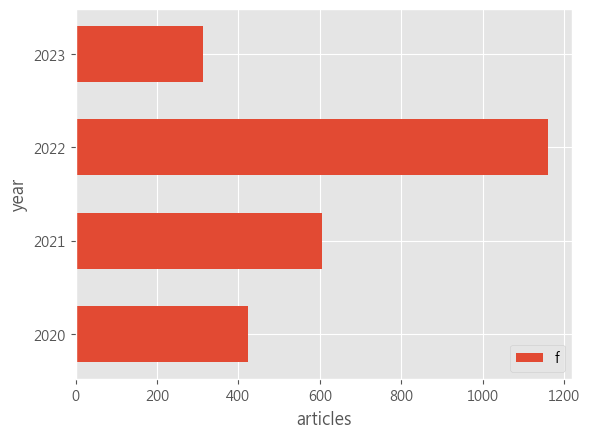

In [56]:
fig, ax = plt.subplots()
tmp = [df_2020.shape[0],df_2021.shape[0],df_2022.shape[0],df_2023.shape[0]]
tmpR = ['2020','2021','2022','2023']
ax.barh(tmpR,
        tmp, 
        height=0.6, 
        align='center')
ax.set_ylabel('year')
ax.set_xlabel('articles')
ax.legend('freq', loc ='lower right') 

In [62]:
df_infirm = df_[df_.content.str.contains(firm_dict["in-firm"])].reset_index(drop=True)
df_outfirm = df_[df_.content.str.contains(firm_dict["out-firm"])].reset_index(drop=True)
print(df_infirm.shape)
print(df_outfirm.shape)

(1, 6)
(49, 6)


In [79]:
print(df_infirm.loc[0,'content'])

【🔥 2022裕隆暑期實習計畫開跑囉～🏃‍】 想把兩個月的暑期時光變得更充實、與眾不同嗎？。 好奇每天路上看到的汽車是如何製造生產出來的嗎？。 如果你/妳是對汽車製造業有熱忱或想一探究竟的同學，。 趕快手刀報名，一起加入我們的行列吧！🫶🏻🤍 #裕隆汽車製造，等你/妳與我們一起駕裕未來！🚗  🌟 招募職缺：。 ▪ 車身生技工程師。 ▪ 車裝生技工程師。 ▪ 智慧醫材工程師。 ▪ 儲能技術工程師。 ▪ 資訊工程師。 ▪ 物料管理師。 ▪ 經營規劃管理師。 ▪ 人力資源管理師 🕰 實習期間：6月27日至9月2日(將視實際狀況做調整)。 💰 實習津貼：基本工資25,250元/月，有提供免費宿舍唷～。 🌟 報名期間：即日起~ 5月22日 (日)。 🌟 面談日期：將另行通知實際日期。 👉🏻 2022暑期實習計劃詳細可參閱104人力銀行：https://reurl.cc/e3mdWQ。 📌【裕隆汽車製造(股)公司】2022暑期實習計劃DM：https://imgur.com/a/JAql8bk 🌟 應徵方式：。 至 https://reurl.cc/QLdYMM 下載並填妥「裕隆汽車暑期實習申請書」，連同「歷年成績單」及其它有利審查資料mail至 YLM_recruit@yulon-motor.com.tw ，信件標題：應徵暑期實習_應徵職缺_ XX大學_姓名。


In [80]:
df_outfirm.loc[0,'content']

'#發文前必看 #違規者刪文 #職缺招募薪資範圍要寫 #屢次違規者踢社團。 大家好，歡迎大家加入實習透視鏡─最透明的實習經驗分享平台的討論區。 高教工會青年行動委員會在2018年9月接手社團，我們希望實習透視鏡能成為全台最多人使用的實習相關問題討論區，提供學生在尋求實習職缺時的參考。目前提供公司實習職缺媒合、實習經驗分享、實習相關訊息分享、實習議題討論等功能，期待大家能善用本社團，為自己以及未來實習者提供有用的資訊。 實習透視鏡旨在讓「實習」這個狀態能夠被清晰看見，過去公司在員工受聘後會進行工作訓練，以學習相關必備的技能，才能對工作更為上手，而今實習常作為正職工作的跳板，許多公司常以實習作為一種召募人才的門檻，再加上教育部積極推廣實習，使不少大專院校學系將實習列為必修課程、畢業門檻，使得實習變得有某種綁架性質。造成實習生有更多的困境無處申訴，為求畢業委曲求全。而實習透視鏡社團希望公司在提供實習職缺時，能夠清楚地揭示該職缺的工作內容，與一般工讀生、低薪工作者的工作有何差異性，能提供更多對實習生的培育。 我們不希望公司藉著實習的名義，來徵求免錢的人力，因此在徵文上要求提供【工作時間】、【薪資待遇】、【有無勞健保】等項目，且必須詳列內容，在薪資待遇上如果未達到最低基本工資要求（2019年最低基本工資為每小時150元、每月23100元），請填「未」達到勞基法最低基本薪資，以讓想參與此實習的成員能夠清楚了解薪資狀況，避免將來產生勞資爭議。 實習經驗網站(目前400多則經驗)➡️ https://internlens.com/。 #社團文章目錄傳送(經驗/求職技巧/懶人包)➡️https://goo.gl/rWNUz4。 Github ➡️ https://github.com/internlens-tw/InternLens。 問卷 raw data➡️ http://qsear.ch/0a1201 --。 [社團發文指南]。 1. 大家對於某某職缺或是任何關於實習的問題也都可以儘管問，可能會有學長姐或大神現身回答你喔～。 2. 利用關鍵字標題幫文章分類，讓大家一眼看出你的主題。。 [薪資] 請問做XXX的工作，拿$$$是合理的嗎？。 [求救] 請問有人面試過NASA的實習嗎？跪求前輩經驗分享！。 [分享] 面試了十家海內外科技公司後，一點經驗分享...。 3. 在文章最後加

In [47]:
df_[(df_.date > '2020-01-01') & (df_.date < '2020-12-10')]

Unnamed: 0        date  \
220          220  2020-11-26   
915          915  2020-03-23   
2144        2144  2020-05-11   
2159        2159  2020-11-16   
2202        2202  2020-11-23   
...          ...         ...   
2663        2663  2020-02-24   
2664        2664  2020-02-24   
2665        2665  2020-02-24   
2666        2666  2020-02-19   
2667        2667  2020-02-17   

                                                content           poster  \
220   #發文前必看 #違規者刪文 #職缺招募薪資範圍以及公司名要寫 #嚴禁無勞健保機會 #嚴禁無薪...              藍偉任   
915   【徵求】長期內容IP共同創業夥伴-企劃文案。 嗨，我們是「羞羞探險隊」！。 是致力於推廣「性...              張瑀庭   
2144  【2020 美商默沙東藥廠實習計畫 MSD Taiwan Internship Progra...              陳汎萱   
2159  【KR AUDIO 愷銳音響長期實習生計畫】。 哈囉大家好，愷銳音響長期的實習生計畫已經邁入...              白詩瑀   
2202  [LRS is HIRING!!]。LRS為一人力資源顧問公司，致力於各項專業領域及產業之人...        Yu Wen Su   
...                                                 ...              ...   
2663  【Recruit Express立可人事實習生招募計畫】。📌招募職位：。 1. 獵才顧問專員...              林玟君   
2664  #生醫新創 #團隊招募 #分享H. Spectrum 孵化器是一個專注於生醫領域的新創培育計...              鄭軒羽   
2665  【#暑期國際實習 Summer School】#法國液空集團 #亞東工業氣體 （Air Li...  Lin Cheng-Hsien   
2666  #暑期實習 #國研院 #分享 。 看到國家實驗研究院開出了有薪暑期實習，分享給有興趣想利用暑...              藍偉任   
2667  🇹🇼🇹🇼2020美商慧與科技股份有限公司 Hewlett Packard Enterpris...     Shannon Chen   

                                              posterUrl  
220   https://mbasic.facebook.com//willy.lan.3?eav=A...  
915   https://mbasic.facebook.com//profile.php?id=10...  
2144  https://mbasic.facebook.com//profile.php?id=10...  
2159  https://mbasic.facebook.com//profile.php?id=10...  
2202  https://mbasic.facebook.com//yuwen.su.520?eav=...  
...                                                 ...  
2663  https://mbasic.facebook.com//sandyypyu?eav=AfY...  
2664  https://mbasic.facebook.com//profile.php?id=10...  
2665  https://mbasic.facebook.com//hsiensays?eav=Afa...  
2666  https://mbasic.facebook.com//willy.lan.3?eav=A...  
2667  https://mbasic.facebook.com//shannon21la?eav=A...  

[423 rows x 5 columns]

In [31]:
(df_.loc[220,'date_format'])

datetime.date(2020, 11, 26)

In [45]:
pf_2020_date = pd.DataFrame(df_2020.groupby("date_format")['date_format'].count())
# print(len(pf_date))
pf_2020_date
pf_2021_date = pd.DataFrame(df_2021.groupby("date_format")['date_format'].count())
pf_2021_date
pf_2022_date = pd.DataFrame(df_2022.groupby("date_format")['date_format'].count())
pf_2022_date
pf_2023_date = pd.DataFrame(df_2023.groupby("date_format")['date_format'].count())
pf_2023_date

date_format
date_format             
2023-01-03             4
2023-01-04             1
2023-01-05             4
2023-01-06             6
2023-01-07             2
...                  ...
2023-04-10             6
2023-04-11             5
2023-04-12             1
2023-04-13             7
2023-04-14             2

[80 rows x 1 columns]

In [25]:
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

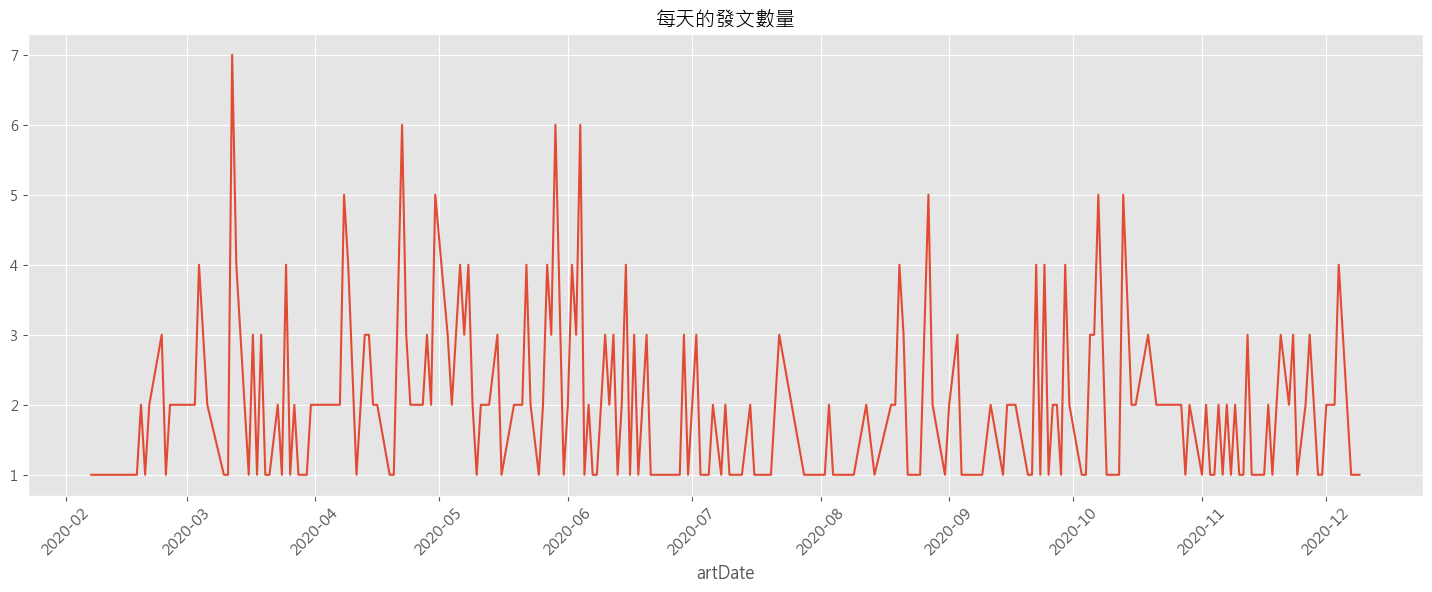

In [38]:
data_datecount = pd.DataFrame(df_2020.groupby('date_format').size(),columns = ['count'])

plt.figure(figsize=(18,6))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.title('每天的發文數量')
plt.xlabel('artDate')
plt.xticks(rotation= 45, fontsize=11)
plt.plot(data_datecount.index,data_datecount['count'].tolist())

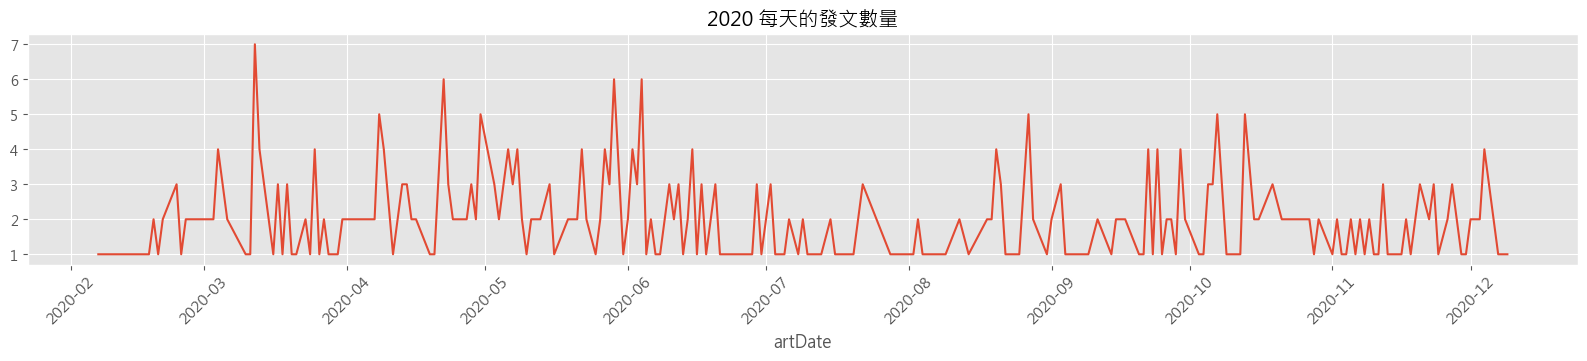

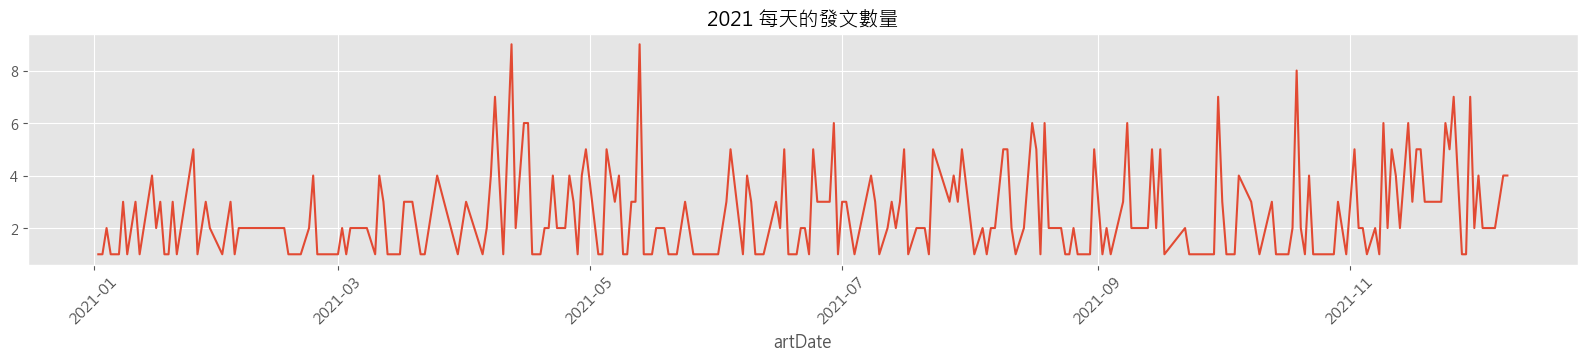

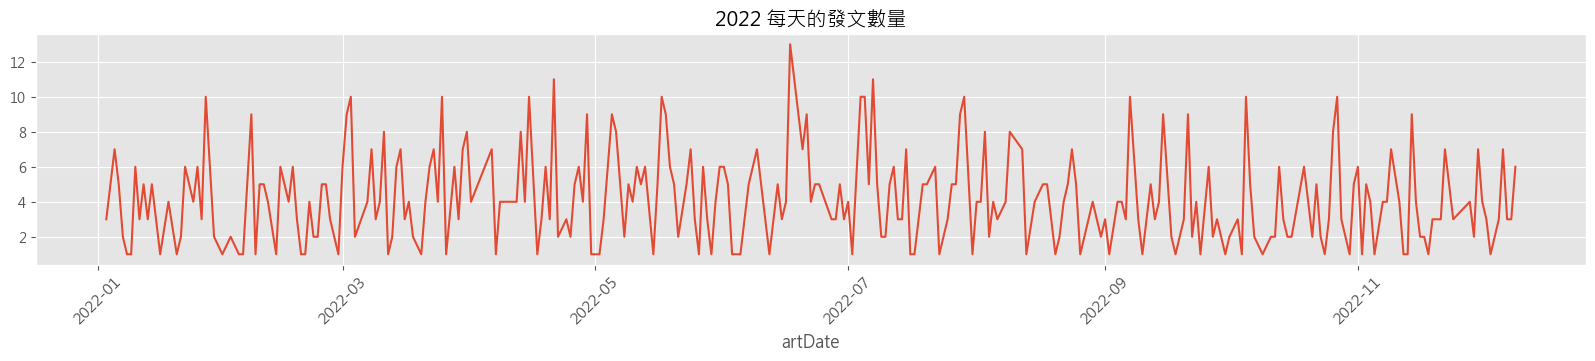

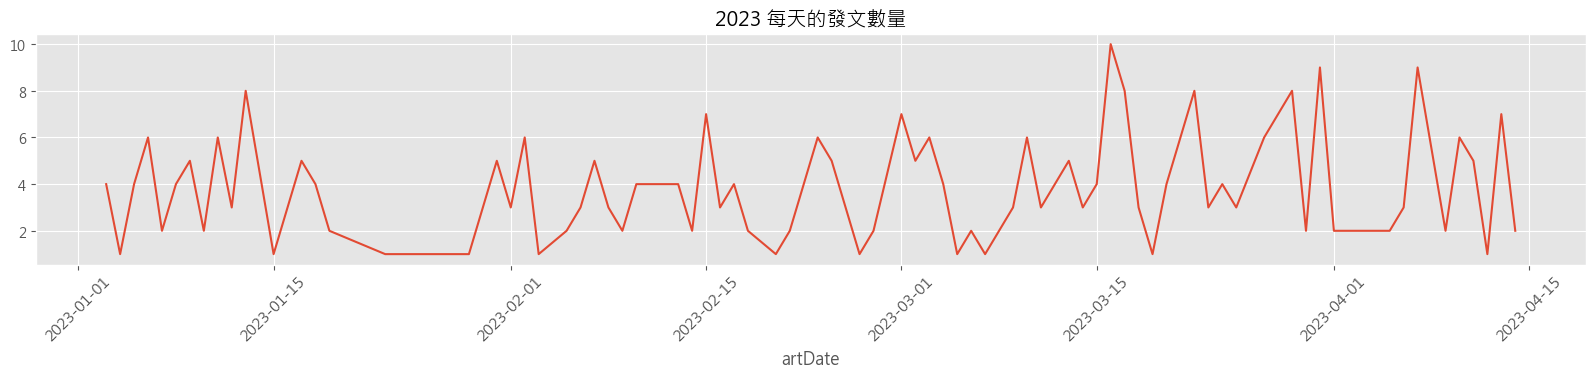

In [58]:
plt.figure(figsize=(20,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.title('2020 每天的發文數量')
plt.xlabel('artDate')
plt.xticks(rotation= 45, fontsize=11)
plt.plot(pf_2020_date.index,pf_2020_date.date_format.to_list())
#---------------------------------------------------------------------
plt.figure(figsize=(20,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.title('2021 每天的發文數量')
plt.xlabel('artDate')
plt.xticks(rotation= 45, fontsize=11)
plt.plot(pf_2021_date.index,pf_2021_date.date_format.to_list())
#---------------------------------------------------------------------
plt.figure(figsize=(20,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.title('2022 每天的發文數量')
plt.xlabel('artDate')
plt.xticks(rotation= 45, fontsize=11)
plt.plot(pf_2022_date.index,pf_2022_date.date_format.to_list())
#---------------------------------------------------------------------
plt.figure(figsize=(20,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.title('2023 每天的發文數量')
plt.xlabel('artDate')
plt.xticks(rotation= 45, fontsize=11)
plt.plot(pf_2023_date.index,pf_2023_date.date_format.to_list())

In [63]:
df_2020infirm = df_2020[df_2020.content.str.contains(firm_dict["in-firm"])].reset_index(drop=True)
df_2020outfirm = df_2020[df_2020.content.str.contains(firm_dict["out-firm"])].reset_index(drop=True)
print(df_2020infirm.shape)
print(df_2020outfirm.shape)
df_2021infirm = df_2021[df_2021.content.str.contains(firm_dict["in-firm"])].reset_index(drop=True)
df_2021outfirm = df_2021[df_2021.content.str.contains(firm_dict["out-firm"])].reset_index(drop=True)
print(df_2021infirm.shape)
print(df_2021outfirm.shape)
df_2022infirm = df_2022[df_2022.content.str.contains(firm_dict["in-firm"])].reset_index(drop=True)
df_2022outfirm = df_2022[df_2022.content.str.contains(firm_dict["out-firm"])].reset_index(drop=True)
print(df_2022infirm.shape)
print(df_2022outfirm.shape)
df_2023infirm = df_2023[df_2023.content.str.contains(firm_dict["in-firm"])].reset_index(drop=True)
df_2023outfirm = df_2023[df_2023.content.str.contains(firm_dict["out-firm"])].reset_index(drop=True)
print(df_2023infirm.shape)
print(df_2023outfirm.shape)

(0, 6)
(11, 6)
(0, 6)
(11, 6)
(1, 6)
(18, 6)
(0, 6)
(7, 6)


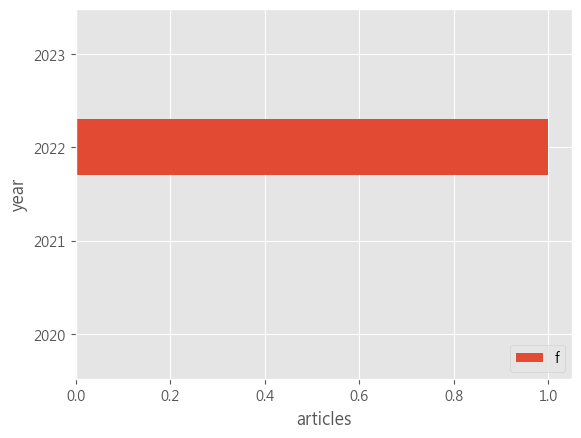

In [67]:
fig, ax = plt.subplots()
tmp = [df_2020infirm.shape[0],df_2021infirm.shape[0],df_2022infirm.shape[0],df_2023infirm.shape[0]]
tmpR = ['2020','2021','2022','2023']
ax.barh(tmpR,
        tmp, 
        height=0.6, 
        align='center')
ax.set_ylabel('year')
ax.set_xlabel('articles')
ax.legend('freq', loc ='lower right') 

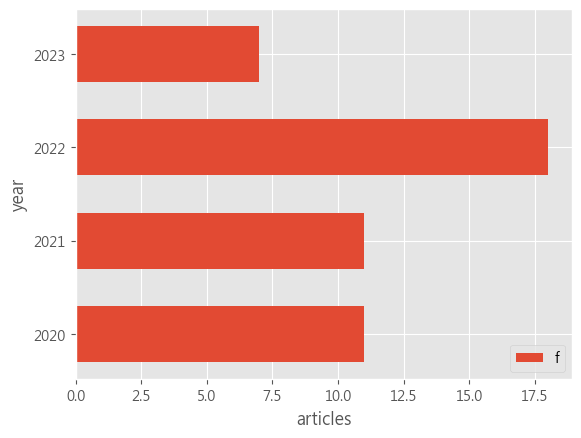

In [68]:
fig, ax = plt.subplots()
tmp = [df_2020outfirm.shape[0],df_2021outfirm.shape[0],df_2022outfirm.shape[0],df_2023outfirm.shape[0]]
tmpR = ['2020','2021','2022','2023']
ax.barh(tmpR,
        tmp, 
        height=0.6, 
        align='center')
ax.set_ylabel('year')
ax.set_xlabel('articles')
ax.legend('freq', loc ='lower right') 

In [ ]:
x = ['企業內','企業外']
y = [df_infirm.shape[0],df_outfirm.shape[0]]
import matplotlib.pyplot as plt
plt.figure()
plt.figure(figsize=(10,6))
plt.bar(x,y)
plt.show()

(246, 6)
(14, 6)
(8, 6)
(150, 6)
(18, 6)
(406, 6)
(160, 6)


<Figure size 640x480 with 0 Axes>

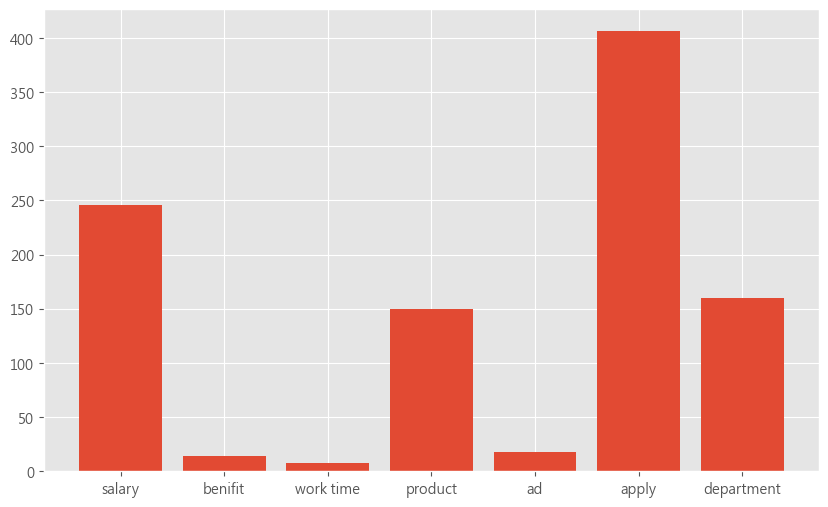

In [70]:
df_2020salary = df_2020[df_2020.content.str.contains(dictionary["薪資"])].reset_index(drop=True)
df_2020benefit = df_2020[df_2020.content.str.contains(dictionary["福利"])].reset_index(drop=True)
df_2020workTime = df_2020[df_2020.content.str.contains(dictionary["工時"])].reset_index(drop=True)
df_2020product = df_2020[df_2020.content.str.contains(dictionary["產品"])].reset_index(drop=True)
df_2020ad = df_2020[df_2020.content.str.contains(dictionary["廣告"])].reset_index(drop=True)
df_2020apply = df_2020[df_2020.content.str.contains(dictionary["人才招募"])].reset_index(drop=True)
df_2020department = df_2020[df_2020.content.str.contains(dictionary["科系專業"])].reset_index(drop=True)
print(df_2020salary.shape)
print(df_2020benefit.shape)
print(df_2020workTime.shape)
print(df_2020product.shape)
print(df_2020ad.shape)
print(df_2020apply.shape)
print(df_2020department.shape)
_df_2020list = [df_2020salary.shape[0],df_2020benefit.shape[0],df_2020workTime.shape[0],df_2020product.shape[0],df_2020ad.shape[0],df_2020apply.shape[0],df_2020department.shape[0]]
category = ['salary','benifit','work time','product','ad','apply','department']
import matplotlib.pyplot as plt
plt.figure()
plt.figure(figsize=(10,6))
plt.bar(category,_df_2020list)
plt.show()

(446, 6)
(9, 6)
(10, 6)
(253, 6)
(22, 6)
(591, 6)
(245, 6)


<Figure size 640x480 with 0 Axes>

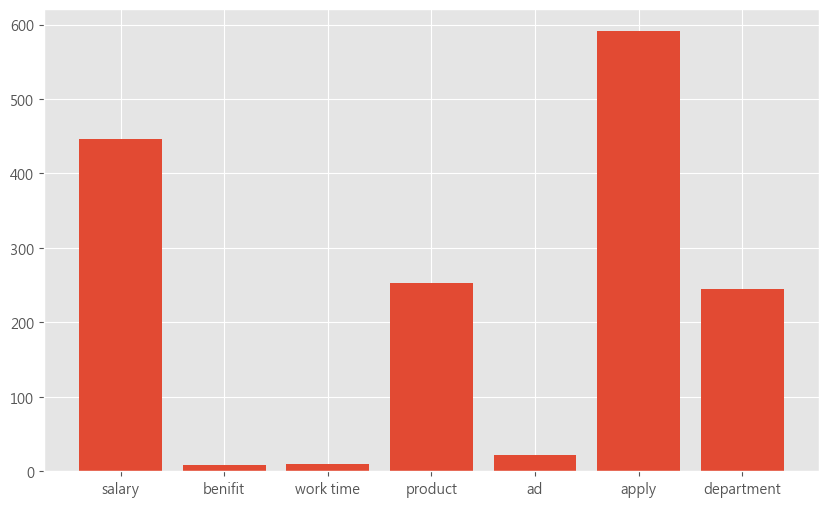

In [71]:
df_2021salary = df_2021[df_2021.content.str.contains(dictionary["薪資"])].reset_index(drop=True)
df_2021benefit = df_2021[df_2021.content.str.contains(dictionary["福利"])].reset_index(drop=True)
df_2021workTime = df_2021[df_2021.content.str.contains(dictionary["工時"])].reset_index(drop=True)
df_2021product = df_2021[df_2021.content.str.contains(dictionary["產品"])].reset_index(drop=True)
df_2021ad = df_2021[df_2021.content.str.contains(dictionary["廣告"])].reset_index(drop=True)
df_2021apply = df_2021[df_2021.content.str.contains(dictionary["人才招募"])].reset_index(drop=True)
df_2021department = df_2021[df_2021.content.str.contains(dictionary["科系專業"])].reset_index(drop=True)
print(df_2021salary.shape)
print(df_2021benefit.shape)
print(df_2021workTime.shape)
print(df_2021product.shape)
print(df_2021ad.shape)
print(df_2021apply.shape)
print(df_2021department.shape)
_df_2021list = [df_2021salary.shape[0],df_2021benefit.shape[0],df_2021workTime.shape[0],df_2021product.shape[0],df_2021ad.shape[0],df_2021apply.shape[0],df_2021department.shape[0]]
category = ['salary','benifit','work time','product','ad','apply','department']
import matplotlib.pyplot as plt
plt.figure()
plt.figure(figsize=(10,6))
plt.bar(category,_df_2021list)
plt.show()

(838, 6)
(24, 6)
(15, 6)
(465, 6)
(45, 6)
(1139, 6)
(435, 6)


<Figure size 640x480 with 0 Axes>

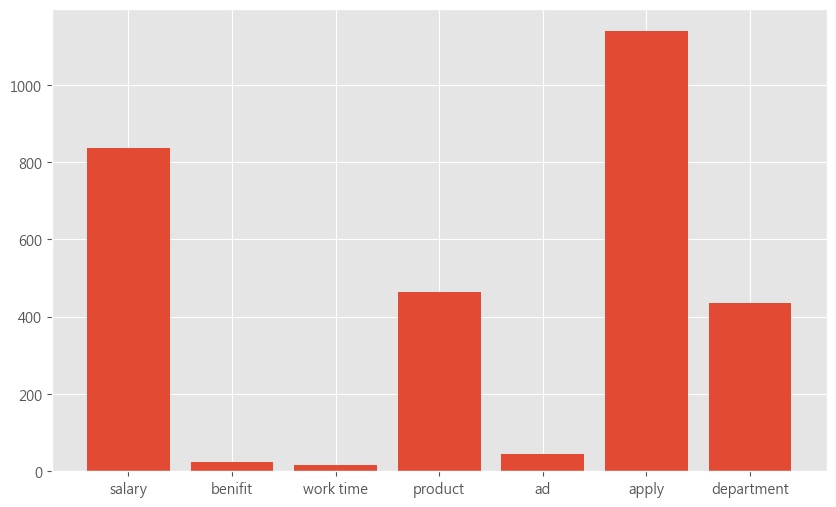

In [72]:
df_2022salary = df_2022[df_2022.content.str.contains(dictionary["薪資"])].reset_index(drop=True)
df_2022benefit = df_2022[df_2022.content.str.contains(dictionary["福利"])].reset_index(drop=True)
df_2022workTime = df_2022[df_2022.content.str.contains(dictionary["工時"])].reset_index(drop=True)
df_2022product = df_2022[df_2022.content.str.contains(dictionary["產品"])].reset_index(drop=True)
df_2022ad = df_2022[df_2022.content.str.contains(dictionary["廣告"])].reset_index(drop=True)
df_2022apply = df_2022[df_2022.content.str.contains(dictionary["人才招募"])].reset_index(drop=True)
df_2022department = df_2022[df_2022.content.str.contains(dictionary["科系專業"])].reset_index(drop=True)
print(df_2022salary.shape)
print(df_2022benefit.shape)
print(df_2022workTime.shape)
print(df_2022product.shape)
print(df_2022ad.shape)
print(df_2022apply.shape)
print(df_2022department.shape)
_df_2022list = [df_2022salary.shape[0],df_2022benefit.shape[0],df_2022workTime.shape[0],df_2022product.shape[0],df_2022ad.shape[0],df_2022apply.shape[0],df_2022department.shape[0]]
category = ['salary','benifit','work time','product','ad','apply','department']
import matplotlib.pyplot as plt
plt.figure()
plt.figure(figsize=(10,6))
plt.bar(category,_df_2022list)
plt.show()

(222, 6)
(4, 6)
(3, 6)
(123, 6)
(11, 6)
(303, 6)
(123, 6)


<Figure size 640x480 with 0 Axes>

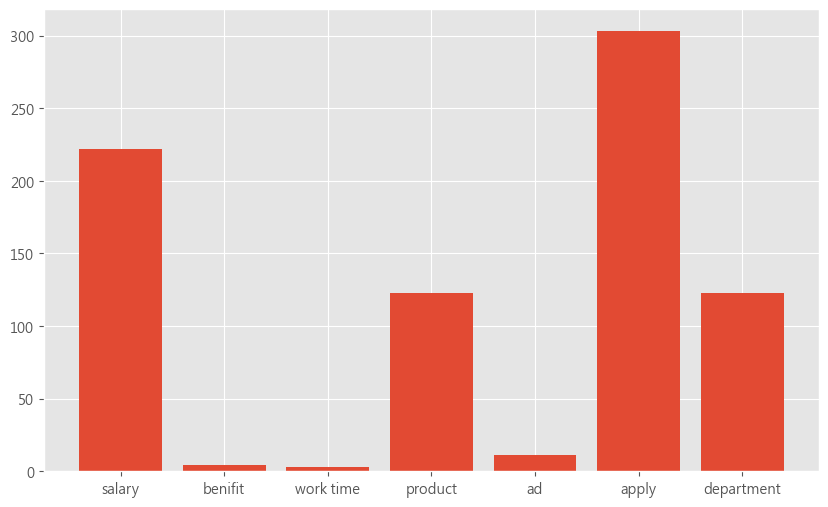

In [73]:
df_2023salary = df_2023[df_2023.content.str.contains(dictionary["薪資"])].reset_index(drop=True)
df_2023benefit = df_2023[df_2023.content.str.contains(dictionary["福利"])].reset_index(drop=True)
df_2023workTime = df_2023[df_2023.content.str.contains(dictionary["工時"])].reset_index(drop=True)
df_2023product = df_2023[df_2023.content.str.contains(dictionary["產品"])].reset_index(drop=True)
df_2023ad = df_2023[df_2023.content.str.contains(dictionary["廣告"])].reset_index(drop=True)
df_2023apply = df_2023[df_2023.content.str.contains(dictionary["人才招募"])].reset_index(drop=True)
df_2023department = df_2023[df_2023.content.str.contains(dictionary["科系專業"])].reset_index(drop=True)
print(df_2023salary.shape)
print(df_2023benefit.shape)
print(df_2023workTime.shape)
print(df_2023product.shape)
print(df_2023ad.shape)
print(df_2023apply.shape)
print(df_2023department.shape)
_df_2023list = [df_2023salary.shape[0],df_2023benefit.shape[0],df_2023workTime.shape[0],df_2023product.shape[0],df_2023ad.shape[0],df_2023apply.shape[0],df_2023department.shape[0]]
category = ['salary','benifit','work time','product','ad','apply','department']
import matplotlib.pyplot as plt
plt.figure()
plt.figure(figsize=(10,6))
plt.bar(category,_df_2023list)
plt.show()

In [23]:
x = ['薪資','福利','工時','產品','廣告','人才招募','專業科目']
y = [df_salary.shape[0],df_benefit.shape[0],df_workTime.shape[0],df_product.shape[0],df_ad.shape[0],df_apply.shape[0],df_department.shape[0]]

<Figure size 640x480 with 0 Axes>

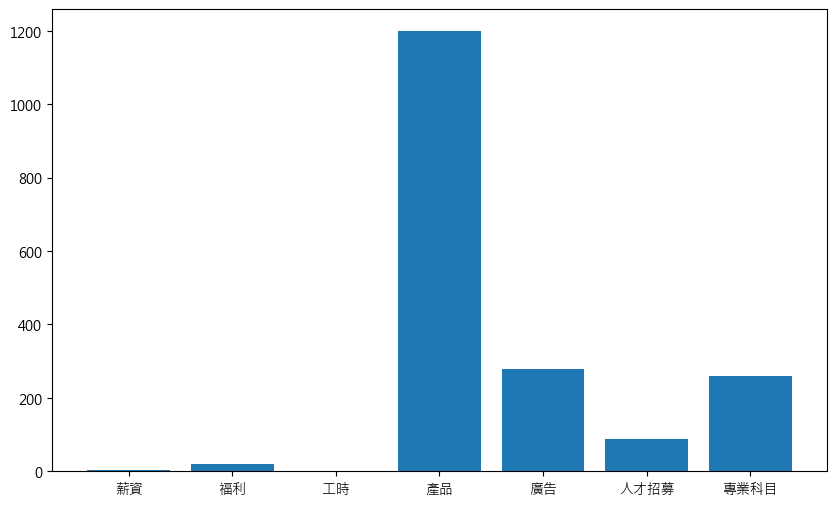

In [28]:
import matplotlib.pyplot as plt
plt.figure()
plt.figure(figsize=(10,6))
plt.bar(x,y)
plt.show()

In [30]:
segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
def sentence_segmentation(df, target_column, segment_symboles=[]):
    regexPattern = '['+'|'.join(segment_symboles)+']'
    sentenceCheckRegexPattern = '[,|.| |\t|\n]'

    result = []
    
    for row_dict in df.to_dict(orient="records"):
        sentences = re.split(regexPattern, row_dict[target_column])
        count = 1
        for sent in sentences:
            if re.sub(sentenceCheckRegexPattern, "", sent):
                temp = row_dict.copy()
                del temp[target_column]
                temp["sentence_idx"] = str(count)
                temp["sentence"] = sent
                result.append(temp)
                count +=1
    df = pd.DataFrame(result)
    return df

### 薪資構面

In [166]:
# df_product.head()
# df_product.sample(n=10,random_state=5,axis=0)

In [54]:
df_sen = sentence_segmentation(df_salary,'artContent',list(segmentation_used_note))
df_salary['sentences'] = df_sen.groupby('artUrl', sort=False)['sentence'].apply(list).tolist()

* 斷詞

In [32]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#新增自定義字典
jieba.load_userdict('./dict/user_dict.txt')
#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from c:\D\中山\31lab\裕隆日產\dict\dict.txt.big ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.u8f690af6935baf7001a90ebf9d4408ff.cache
Loading model cost 0.864 seconds.
Prefix dict has been built succesfully.


In [33]:
def getToken(row):
    
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [55]:
df_sen['word'] =df_sen.sentence.apply(getToken)
df_sen = df_sen.explode('word') # 將word欄位展開

In [56]:
ptt_articleFreq_df = pd.DataFrame(df_sen['word'].value_counts())
ptt_articleFreq_df = ptt_articleFreq_df.reset_index()
ptt_articleFreq_df.columns = ['word', 'freq']
ptt_articleFreq_df

word  freq
0        百萬     8
1       URX     7
2        新店     6
3        汽車     6
4    NISSAN     5
..      ...   ...
179      全台     1
180      舉辦     1
181      學校     1
182      中山     1
183      超高     1

[184 rows x 2 columns]

In [36]:
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

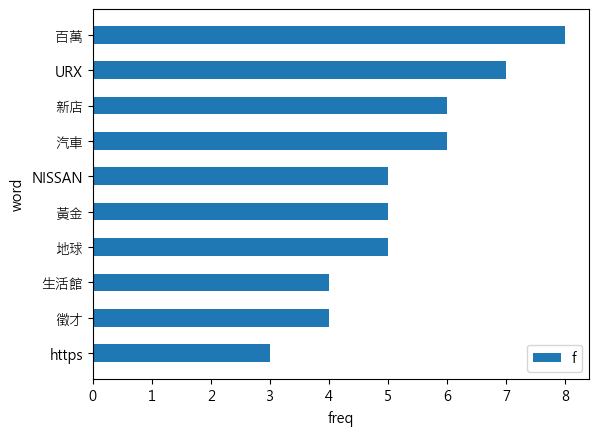

In [57]:
fig, ax = plt.subplots()
tmp = ptt_articleFreq_df['word'][:10]
tmpR = [tmp[i] for i in range(len(tmp)-1,-1,-1)]
ax.barh(tmpR,
        sorted(ptt_articleFreq_df['freq'][:10]), 
        height=0.5, 
        align='center',
        label='freq')
ax.set_ylabel('word')
ax.set_xlabel('freq')
ax.legend('freq', loc ='lower right') 

In [78]:
stop_word_update = stopWords + ['https','3HXmTkr','黃金','地球','ly','NISSAN','bit','新店','生活館']

In [79]:
for index,sentence in enumerate(df_sen['word']):
    if sentence in stop_word_update:
        df_sen = df_sen[~df_sen['word'].isin([sentence])]
ptt_articleFreq_df = pd.DataFrame(df_sen['word'].value_counts())
ptt_articleFreq_df = ptt_articleFreq_df.reset_index()
ptt_articleFreq_df.columns = ['word', 'freq']
ptt_articleFreq_df

word  freq
0     百萬     8
1    URX     7
2     汽車     6
3     徵才     4
4     校園     3
..   ...   ...
171   舉辦     1
172   學校     1
173   中山     1
174  北科大     1
175   超高     1

[176 rows x 2 columns]

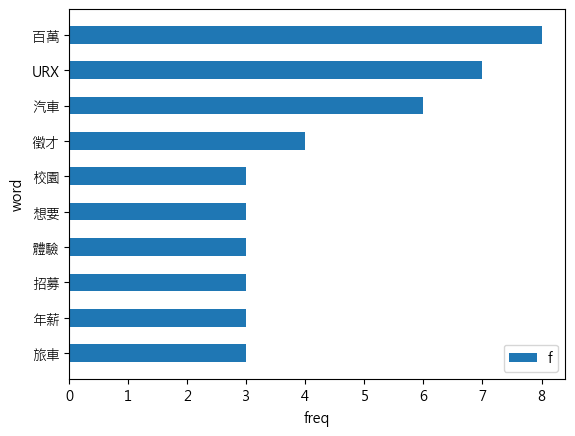

In [80]:
fig, ax = plt.subplots()
tmp = ptt_articleFreq_df['word'][:10]
tmpR = [tmp[i] for i in range(len(tmp)-1,-1,-1)]
ax.barh(tmpR,
        sorted(ptt_articleFreq_df['freq'][:10]), 
        height=0.5, 
        align='center',
        label='freq')
ax.set_ylabel('word')
ax.set_xlabel('freq')
ax.legend('freq', loc ='lower right') 

<Figure size 640x480 with 0 Axes>

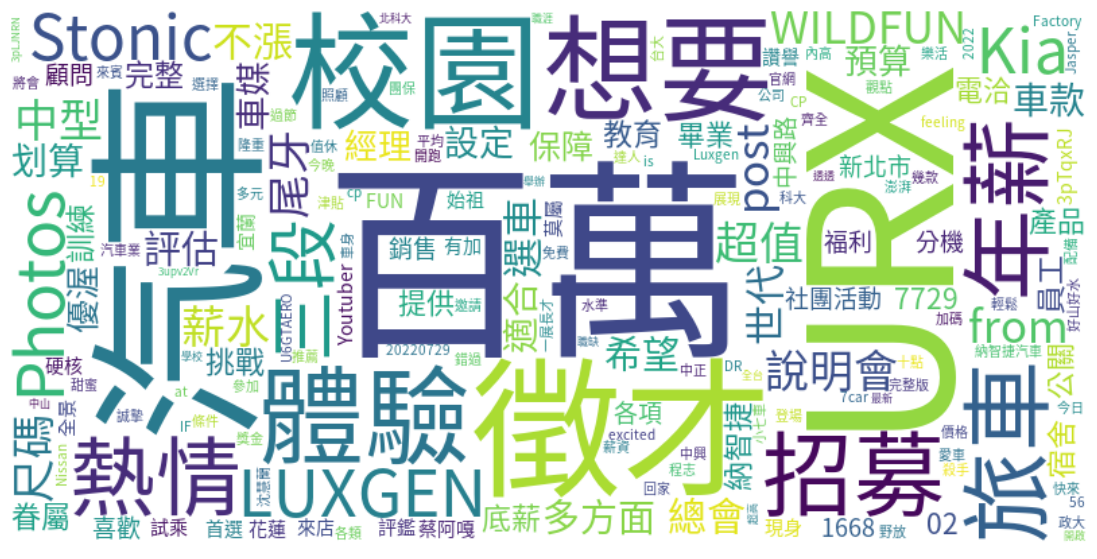

In [81]:
# Generate a word cloud image
font_path = './SourceHanSansTW-Regular.otf'
cloud = WordCloud(max_words=300, background_color="white",width=800, height = 400, font_path=font_path, colormap='viridis')
cloud.generate_from_frequencies({w[1]['word'] : int(w[1]['freq']) for w in ptt_articleFreq_df.iterrows()})
# 繪圖
plt.figure()
plt.figure(figsize=(14,7))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 福利構面

In [43]:
df_benefit.shape

(19, 6)

In [44]:
df_sen = sentence_segmentation(df_benefit,'artContent',list(segmentation_used_note))
df_benefit['sentences'] = df_sen.groupby('artUrl', sort=False)['sentence'].apply(list).tolist()
df_sen['word'] =df_sen.sentence.apply(getToken)
df_sen = df_sen.explode('word') # 將word欄位展開
ptt_articleFreq_df = pd.DataFrame(df_sen['word'].value_counts())
ptt_articleFreq_df = ptt_articleFreq_df.reset_index()
ptt_articleFreq_df.columns = ['word', 'freq']
ptt_articleFreq_df

word  freq
0    NISSAN    22
1    Nissan    19
2        汽車    15
3     https    12
4        終於    11
..      ...   ...
868      科技     1
869    一應俱全     1
870      省油     1
871    應有盡有     1
872      文化     1

[873 rows x 2 columns]

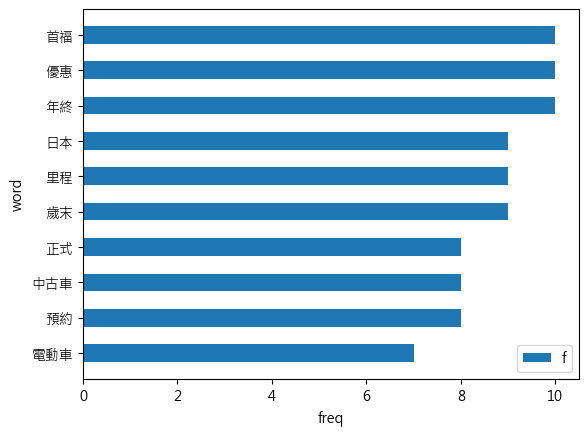

In [53]:
fig, ax = plt.subplots()
tmp = ptt_articleFreq_df['word'][:10]
tmpR = [tmp[i] for i in range(len(tmp)-1,-1,-1)]
ax.barh(tmpR,
        sorted(ptt_articleFreq_df['freq'][:10]), 
        height=0.5, 
        align='center',
        label='freq')
ax.set_ylabel('word')
ax.set_xlabel('freq')
ax.legend('freq', loc ='lower right') 

In [51]:
stop_word_update = stopWords + ['https','Nissan','NISSAN','汽車','終於','推出','無限']
for index,sentence in enumerate(df_sen['word']):
    if sentence in stop_word_update:
        df_sen = df_sen[~df_sen['word'].isin([sentence])]
ptt_articleFreq_df = pd.DataFrame(df_sen['word'].value_counts())
ptt_articleFreq_df = ptt_articleFreq_df.reset_index()
ptt_articleFreq_df.columns = ['word', 'freq']
ptt_articleFreq_df

word  freq
0      首福    10
1      優惠    10
2      年終    10
3      日本     9
4      里程     9
..    ...   ...
861    科技     1
862  一應俱全     1
863    省油     1
864  應有盡有     1
865    文化     1

[866 rows x 2 columns]

<Figure size 640x480 with 0 Axes>

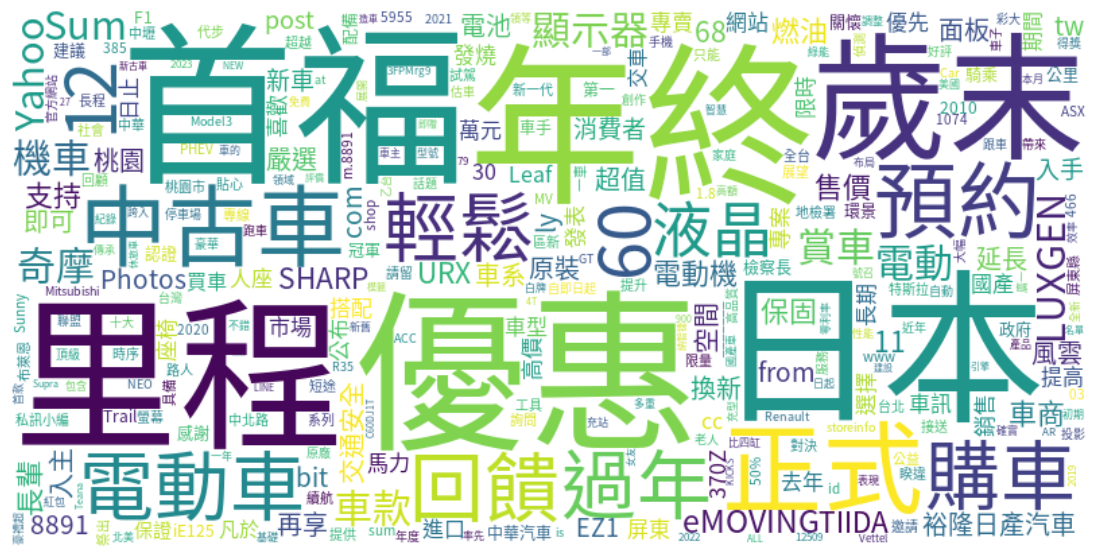

In [52]:
# Generate a word cloud image
font_path = './SourceHanSansTW-Regular.otf'
cloud = WordCloud(max_words=300, background_color="white",width=800, height = 400, font_path=font_path, colormap='viridis')
cloud.generate_from_frequencies({w[1]['word'] : int(w[1]['freq']) for w in ptt_articleFreq_df.iterrows()})
# 繪圖
plt.figure()
plt.figure(figsize=(14,7))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
df_salary = df_[df_.artContent.str.contains(dictionary["薪資"])].reset_index(drop=True)
df_benefit = df_[df_.artContent.str.contains(dictionary["福利"])].reset_index(drop=True)
df_workTime = df_[df_.artContent.str.contains(dictionary["工時"])].reset_index(drop=True)
df_product = df_[df_.artContent.str.contains(dictionary["產品"])].reset_index(drop=True)
df_ad = df_[df_.artContent.str.contains(dictionary["廣告"])].reset_index(drop=True)
df_apply = df_[df_.artContent.str.contains(dictionary["人才招募"])].reset_index(drop=True)
df_department = df_[df_.artContent.str.contains(dictionary["科系專業"])].reset_index(drop=True)

### 工時 = 0

### 產品

In [82]:
df_product.shape

(1199, 6)

In [83]:
df_sen = sentence_segmentation(df_product,'artContent',list(segmentation_used_note))
df_product['sentences'] = df_sen.groupby('artUrl', sort=False)['sentence'].apply(list).tolist()
df_sen['word'] =df_sen.sentence.apply(getToken)
df_sen = df_sen.explode('word') # 將word欄位展開
ptt_articleFreq_df = pd.DataFrame(df_sen['word'].value_counts())
ptt_articleFreq_df = ptt_articleFreq_df.reset_index()
ptt_articleFreq_df.columns = ['word', 'freq']
ptt_articleFreq_df

word  freq
0        https  1150
1       Nissan   990
2       LUXGEN   758
3          URX   712
4           全新   550
...        ...   ...
12074       其即     1
12075  2X21JML     1
12076   MadVnz     1
12077       播放     1
12078       海攻     1

[12079 rows x 2 columns]

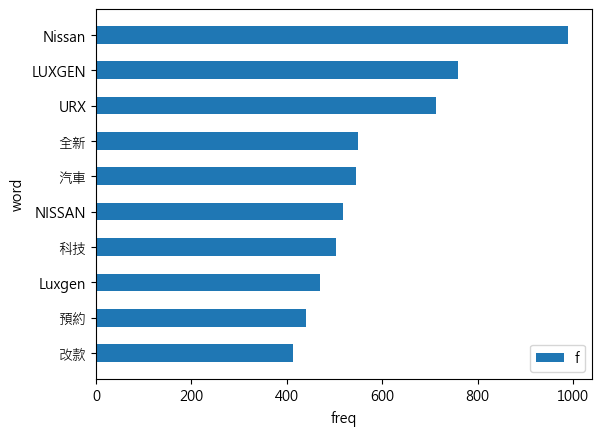

In [65]:
fig, ax = plt.subplots()
tmp = ptt_articleFreq_df['word'][:10]
tmpR = [tmp[i] for i in range(len(tmp)-1,-1,-1)]
ax.barh(tmpR,
        sorted(ptt_articleFreq_df['freq'][:10]), 
        height=0.5, 
        align='center',
        label='freq')
ax.set_ylabel('word')
ax.set_xlabel('freq')
ax.legend('freq', loc ='lower right') 

In [84]:
stop_word_update = stopWords + ['https','2X21JML','其即','Nissan','NISSAN','Luxgen','LUXGEN','68474','MadVnz','現正','3JjBoz4']
for index,sentence in enumerate(df_sen['word']):
    if sentence in stop_word_update:
        df_sen = df_sen[~df_sen['word'].isin([sentence])]
ptt_articleFreq_df = pd.DataFrame(df_sen['word'].value_counts())
ptt_articleFreq_df = ptt_articleFreq_df.reset_index()
ptt_articleFreq_df.columns = ['word', 'freq']
ptt_articleFreq_df

word  freq
0      URX   712
1       全新   550
2       汽車   546
3       科技   504
4       預約   440
...    ...   ...
12063   未定     1
12064   播放     1
12065  著小編     1
12066   深深     1
12067   海攻     1

[12068 rows x 2 columns]

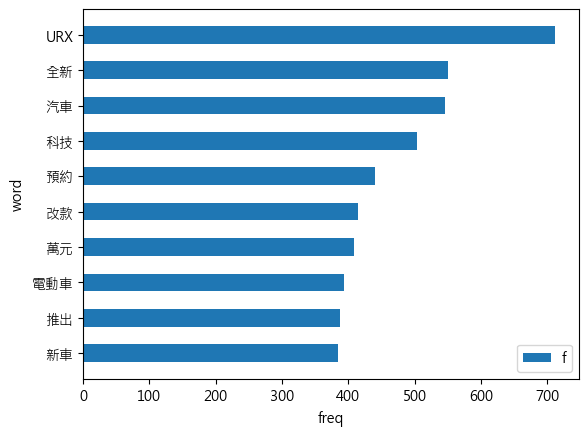

In [69]:
fig, ax = plt.subplots()
tmp = ptt_articleFreq_df['word'][:10]
tmpR = [tmp[i] for i in range(len(tmp)-1,-1,-1)]
ax.barh(tmpR,
        sorted(ptt_articleFreq_df['freq'][:10]), 
        height=0.5, 
        align='center',
        label='freq')
ax.set_ylabel('word')
ax.set_xlabel('freq')
ax.legend('freq', loc ='lower right') 

<Figure size 640x480 with 0 Axes>

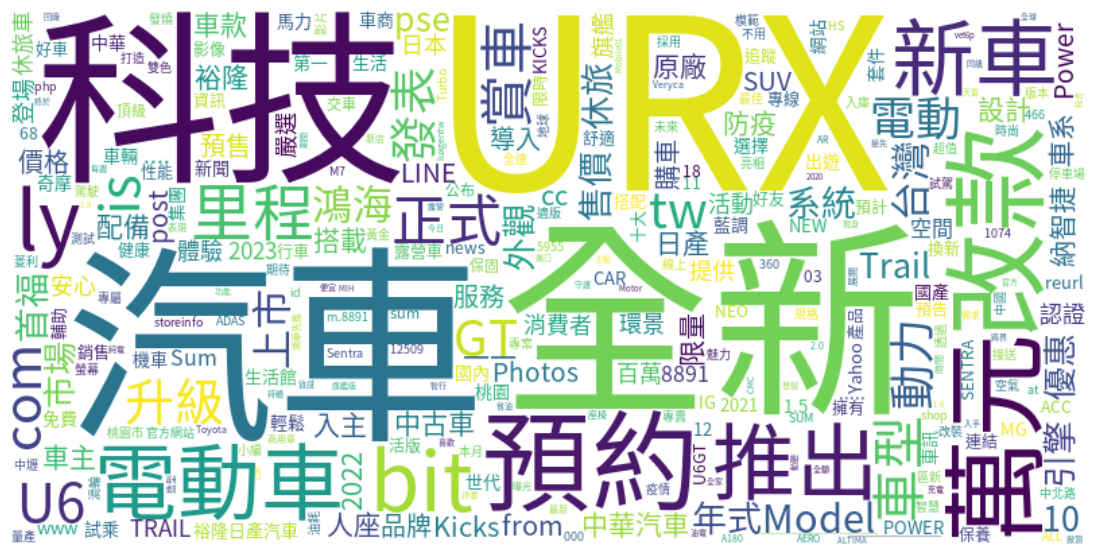

In [85]:
# Generate a word cloud image
font_path = './SourceHanSansTW-Regular.otf'
cloud = WordCloud(max_words=300, background_color="white",width=800, height = 400, font_path=font_path, colormap='viridis')
cloud.generate_from_frequencies({w[1]['word'] : int(w[1]['freq']) for w in ptt_articleFreq_df.iterrows()})
# 繪圖
plt.figure()
plt.figure(figsize=(14,7))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 廣告

In [71]:
df_ad.shape

(278, 6)

In [72]:
df_sen = sentence_segmentation(df_ad,'artContent',list(segmentation_used_note))
df_ad['sentences'] = df_sen.groupby('artUrl', sort=False)['sentence'].apply(list).tolist()
df_sen['word'] =df_sen.sentence.apply(getToken)
df_sen = df_sen.explode('word') # 將word欄位展開
ptt_articleFreq_df = pd.DataFrame(df_sen['word'].value_counts())
ptt_articleFreq_df = ptt_articleFreq_df.reset_index()
ptt_articleFreq_df.columns = ['word', 'freq']
ptt_articleFreq_df

word  freq
0      https   363
1     LUXGEN   325
2        URX   223
3     NISSAN   200
4        生活館   186
...      ...   ...
4645      質疑     1
4646      自行     1
4647     預告片     1
4648     動畫片     1
4649     新聞網     1

[4650 rows x 2 columns]

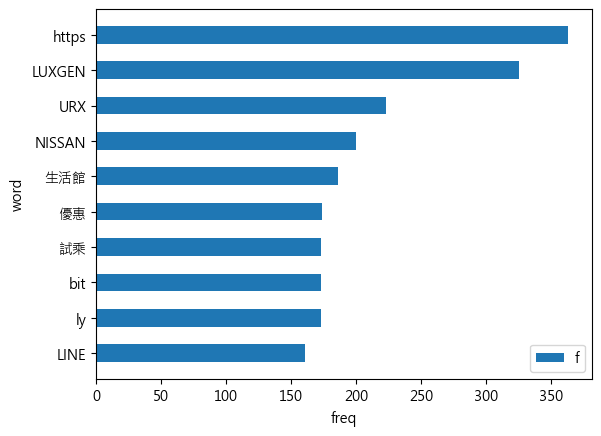

In [73]:
fig, ax = plt.subplots()
tmp = ptt_articleFreq_df['word'][:10]
tmpR = [tmp[i] for i in range(len(tmp)-1,-1,-1)]
ax.barh(tmpR,
        sorted(ptt_articleFreq_df['freq'][:10]), 
        height=0.5, 
        align='center',
        label='freq')
ax.set_ylabel('word')
ax.set_xlabel('freq')
ax.legend('freq', loc ='lower right') 

In [81]:
stop_word_update = stopWords + ['https','LUXGEN','NISSAN','生活館','ly','is','阿爸','bit','Luxgen','點還會','有夠','新聞網']
for index,sentence in enumerate(df_sen['word']):
    if sentence in stop_word_update:
        df_sen = df_sen[~df_sen['word'].isin([sentence])]
ptt_articleFreq_df = pd.DataFrame(df_sen['word'].value_counts())
ptt_articleFreq_df = ptt_articleFreq_df.reset_index()
ptt_articleFreq_df.columns = ['word', 'freq']
ptt_articleFreq_df

word  freq
0      URX   223
1       優惠   174
2       試乘   173
3     LINE   161
4       預約   158
...    ...   ...
4633    致詞     1
4634    指出     1
4635    有人     1
4636    質疑     1
4637  TVBS     1

[4638 rows x 2 columns]

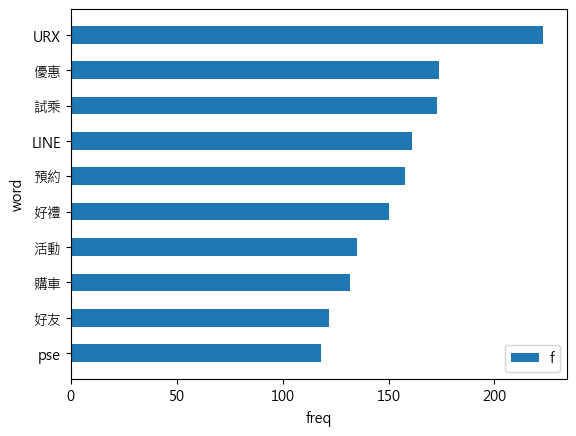

In [82]:
fig, ax = plt.subplots()
tmp = ptt_articleFreq_df['word'][:10]
tmpR = [tmp[i] for i in range(len(tmp)-1,-1,-1)]
ax.barh(tmpR,
        sorted(ptt_articleFreq_df['freq'][:10]), 
        height=0.5, 
        align='center',
        label='freq')
ax.set_ylabel('word')
ax.set_xlabel('freq')
ax.legend('freq', loc ='lower right') 

<Figure size 640x480 with 0 Axes>

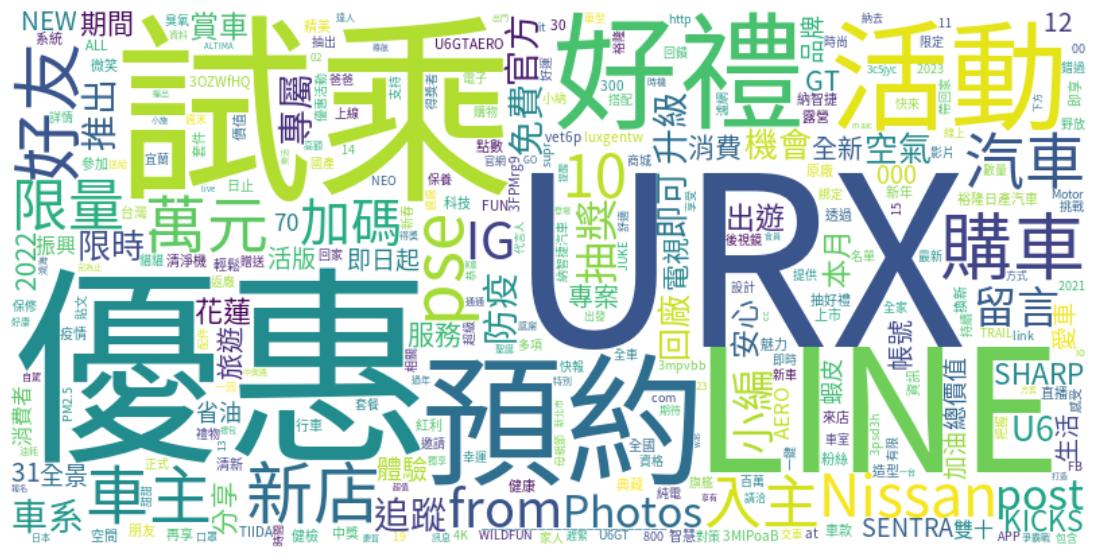

In [83]:
# Generate a word cloud image
font_path = './SourceHanSansTW-Regular.otf'
cloud = WordCloud(max_words=300, background_color="white",width=800, height = 400, font_path=font_path, colormap='viridis')
cloud.generate_from_frequencies({w[1]['word'] : int(w[1]['freq']) for w in ptt_articleFreq_df.iterrows()})
# 繪圖
plt.figure()
plt.figure(figsize=(14,7))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 人才招募

In [84]:
df_apply.shape

(88, 6)

In [85]:
df_sen = sentence_segmentation(df_apply,'artContent',list(segmentation_used_note))
df_apply['sentences'] = df_sen.groupby('artUrl', sort=False)['sentence'].apply(list).tolist()
df_sen['word'] =df_sen.sentence.apply(getToken)
df_sen = df_sen.explode('word') # 將word欄位展開
ptt_articleFreq_df = pd.DataFrame(df_sen['word'].value_counts())
ptt_articleFreq_df = ptt_articleFreq_df.reset_index()
ptt_articleFreq_df.columns = ['word', 'freq']
ptt_articleFreq_df

word  freq
0     https   126
1        服務   100
2        防疫    96
3        預約    94
4        朋友    94
...     ...   ...
2407     得要     1
2408     爸爸     1
2409     想當     1
2410     證言     1
2411     等級     1

[2412 rows x 2 columns]

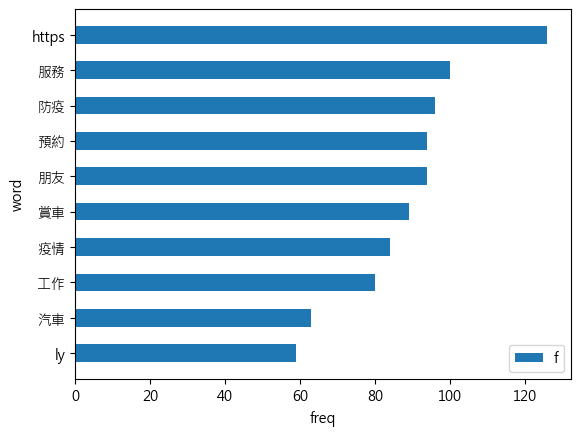

In [86]:
fig, ax = plt.subplots()
tmp = ptt_articleFreq_df['word'][:10]
tmpR = [tmp[i] for i in range(len(tmp)-1,-1,-1)]
ax.barh(tmpR,
        sorted(ptt_articleFreq_df['freq'][:10]), 
        height=0.5, 
        align='center',
        label='freq')
ax.set_ylabel('word')
ax.set_xlabel('freq')
ax.legend('freq', loc ='lower right') 

In [93]:
stop_word_update = stopWords + ['https','爸爸','ly','超狂','先有','想當','bit','一位','cc']
for index,sentence in enumerate(df_sen['word']):
    if sentence in stop_word_update:
        df_sen = df_sen[~df_sen['word'].isin([sentence])]
ptt_articleFreq_df = pd.DataFrame(df_sen['word'].value_counts())
ptt_articleFreq_df = ptt_articleFreq_df.reset_index()
ptt_articleFreq_df.columns = ['word', 'freq']
ptt_articleFreq_df

word  freq
0          服務   100
1          防疫    96
2          預約    94
3          朋友    94
4          賞車    89
...       ...   ...
2397       好車     1
2398      帶回家     1
2399     18.5     1
2400  3lteB8c     1
2401       等級     1

[2402 rows x 2 columns]

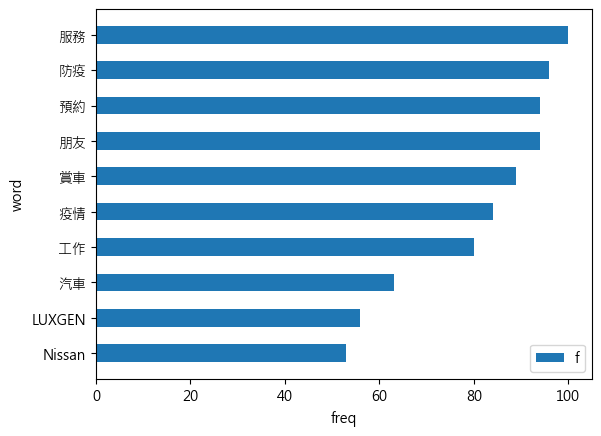

In [94]:
fig, ax = plt.subplots()
tmp = ptt_articleFreq_df['word'][:10]
tmpR = [tmp[i] for i in range(len(tmp)-1,-1,-1)]
ax.barh(tmpR,
        sorted(ptt_articleFreq_df['freq'][:10]), 
        height=0.5, 
        align='center',
        label='freq')
ax.set_ylabel('word')
ax.set_xlabel('freq')
ax.legend('freq', loc ='lower right') 

<Figure size 640x480 with 0 Axes>

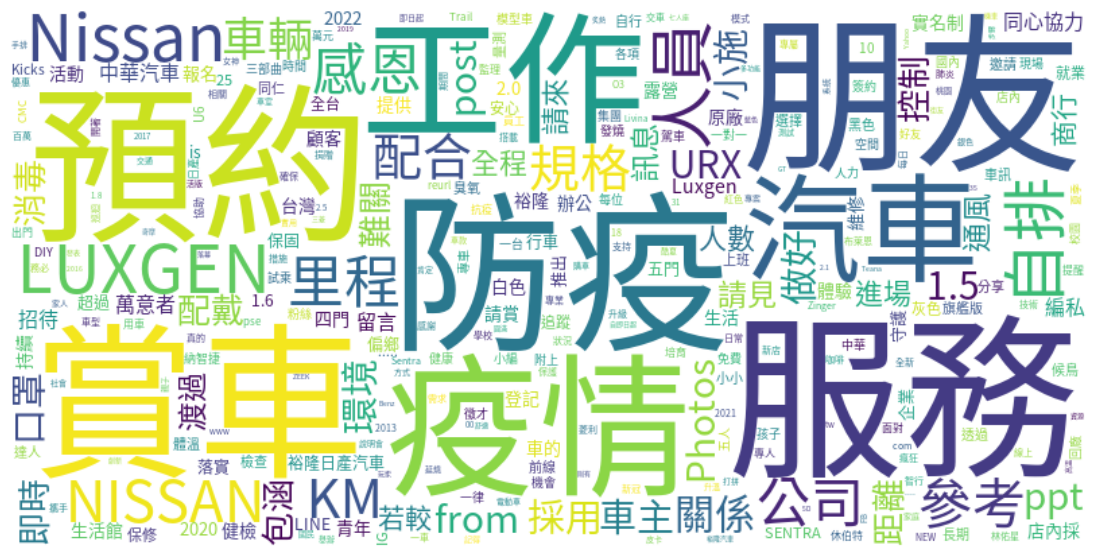

In [95]:
# Generate a word cloud image
font_path = './SourceHanSansTW-Regular.otf'
cloud = WordCloud(max_words=300, background_color="white",width=800, height = 400, font_path=font_path, colormap='viridis')
cloud.generate_from_frequencies({w[1]['word'] : int(w[1]['freq']) for w in ptt_articleFreq_df.iterrows()})
# 繪圖
plt.figure()
plt.figure(figsize=(14,7))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 科系專業

In [96]:
df_department.shape

(260, 6)

In [97]:
df_sen = sentence_segmentation(df_department,'artContent',list(segmentation_used_note))
df_department['sentences'] = df_sen.groupby('artUrl', sort=False)['sentence'].apply(list).tolist()
df_sen['word'] =df_sen.sentence.apply(getToken)
df_sen = df_sen.explode('word') # 將word欄位展開
ptt_articleFreq_df = pd.DataFrame(df_sen['word'].value_counts())
ptt_articleFreq_df = ptt_articleFreq_df.reset_index()
ptt_articleFreq_df.columns = ['word', 'freq']
ptt_articleFreq_df

word  freq
0      https   296
1         汽車   248
2         里程   211
3        com   193
4     Nissan   193
...      ...   ...
4827      黑化     1
4828      與眾     1
4829     個性化     1
4830      共計     1
4831     年銷量     1

[4832 rows x 2 columns]

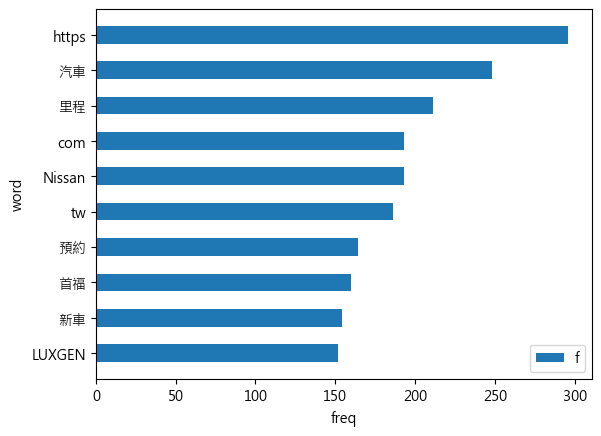

In [98]:
fig, ax = plt.subplots()
tmp = ptt_articleFreq_df['word'][:10]
tmpR = [tmp[i] for i in range(len(tmp)-1,-1,-1)]
ax.barh(tmpR,
        sorted(ptt_articleFreq_df['freq'][:10]), 
        height=0.5, 
        align='center',
        label='freq')
ax.set_ylabel('word')
ax.set_xlabel('freq')
ax.legend('freq', loc ='lower right') 

In [100]:
stop_word_update = stopWords + ['https','com','LUXGEN','tw','Nissan']
for index,sentence in enumerate(df_sen['word']):
    if sentence in stop_word_update:
        df_sen = df_sen[~df_sen['word'].isin([sentence])]
ptt_articleFreq_df = pd.DataFrame(df_sen['word'].value_counts())
ptt_articleFreq_df = ptt_articleFreq_df.reset_index()
ptt_articleFreq_df.columns = ['word', 'freq']
ptt_articleFreq_df

word  freq
0      汽車   248
1      里程   211
2      預約   164
3      首福   160
4      新車   154
...   ...   ...
4822   黑化     1
4823   與眾     1
4824  個性化     1
4825   共計     1
4826  年銷量     1

[4827 rows x 2 columns]

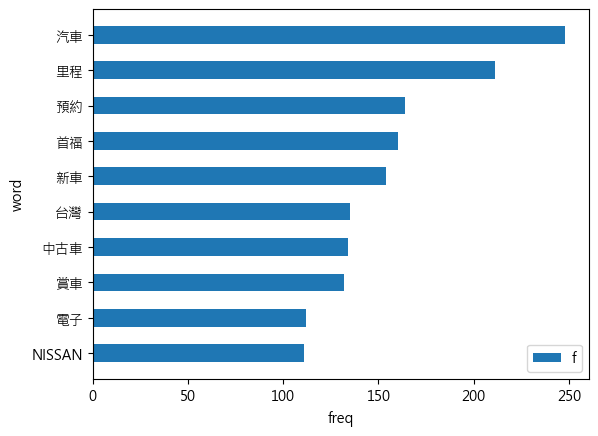

In [101]:
fig, ax = plt.subplots()
tmp = ptt_articleFreq_df['word'][:10]
tmpR = [tmp[i] for i in range(len(tmp)-1,-1,-1)]
ax.barh(tmpR,
        sorted(ptt_articleFreq_df['freq'][:10]), 
        height=0.5, 
        align='center',
        label='freq')
ax.set_ylabel('word')
ax.set_xlabel('freq')
ax.legend('freq', loc ='lower right') 

<Figure size 640x480 with 0 Axes>

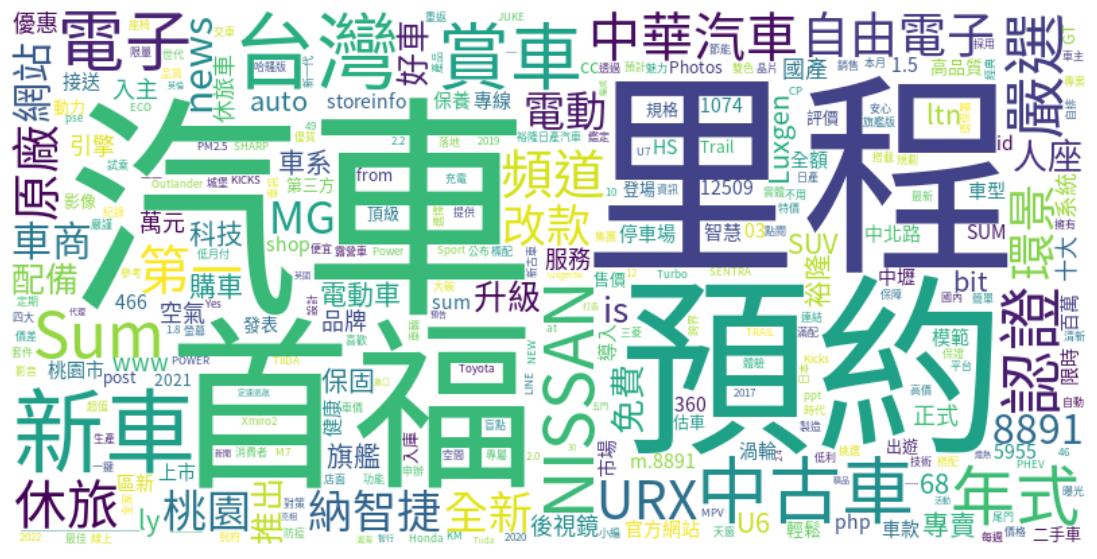

In [102]:
# Generate a word cloud image
font_path = './SourceHanSansTW-Regular.otf'
cloud = WordCloud(max_words=300, background_color="white",width=800, height = 400, font_path=font_path, colormap='viridis')
cloud.generate_from_frequencies({w[1]['word'] : int(w[1]['freq']) for w in ptt_articleFreq_df.iterrows()})
# 繪圖
plt.figure()
plt.figure(figsize=(14,7))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()